# ImageNet Example All Metrics

In this notebook, we will demonstrate the functionality of the various evaluation metrics included in the library.

For this purpose, we use a pre-trained ResNet18 from `torchvision` and ImageNet dataset.

**Prerequisites**
- <a href="">Tutorial: ImageNet Example All Explainers</a>

**Contents**
1. [Preliminaries](#preliminaries)
    - [Load a pre-trained model and data](#model-and-data)
    - [Prepare explanations to be compared](#expl)
2. [Evaluation using `pnpxai`](#eval)
    - [MuFidelity](#mufd)
    - [Sensitivity](#sens)
    - [Complexity](#cmpx)
    - [Visualize all](#vis)

## 1. Preliminaries<a name="preliminaries"></a>

### 1.1 Load a pre-trained model and data<a name="model-and-data"></a>

In this example, we load a pre-trained ResNet18 from `torchvison`. We have prepared `get_torchvision_model(model_name: str)` for tutorials, which returns a pre-trained model and its default data transformation from the model name. Also, we've prepared a subset of ImageNet dataset and `get_imagenet_dataset(transform)` which loads the dataset. Loads the data.

Loads the model and data.

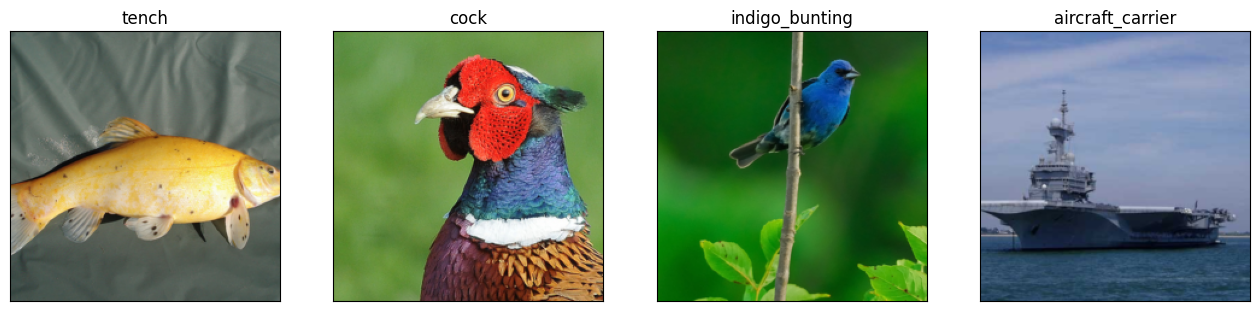

In [1]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

from helpers import get_imagenet_dataset, get_torchvision_model

# load pretrained resnet18 from torchvision
model, transform = get_torchvision_model("resnet18")

# load data
indices = [0, 7, 14, 403]
dataset = get_imagenet_dataset(
    transform=transform,
    indices=indices,
    root_dir="./data/ImageNet"
)
dataloader = DataLoader(dataset=dataset, batch_size=len(indices))
inputs, labels = next(iter(dataloader))

# denormalize input data
def denormalize_image(inputs, mean, std):
    return (
        inputs
        * torch.Tensor(std)[:, None, None]
        + torch.Tensor(mean)[:, None, None]
    ).permute(1, 2, 0).detach().numpy()

# show images
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for c, (input, label) in enumerate(zip(inputs, labels)):
    axes[c].imshow(denormalize_image(input, mean=transform.mean, std=transform.std))
    axes[c].set_title(dataset.dataset.idx_to_label(label.item()))
    axes[c].set_xticks([])
    axes[c].set_yticks([])

### 1.2 Prepare explanations to be compared<a name="expl"></a>

In this example, we compare `LRP` and `GradCam` by using evaluation metrics. If you are not farmiliar with usage of `pnpxai.explainers`, please see the [prerequisite](#./imagenet_example_all_explainers) as a preliminary. Prepares explanations by following steps.

**Creating explainers**

Creates explainers.

In [2]:
from pnpxai.explainers import LRP, GradCam

lrp = LRP(model)
gcam = GradCam(model)

**Wrapping the explainers up with keyword arguments for `Explainer.attribute` method**

To transfer keyword arguments, or variables, for `Explainer.attribute` method to a metric instance, it is required to wrap an explainer up using `ExplainerWArgs`. Then, the wrapped explainer computes attributions for input data with the predefined variables. For example, `LRP` explainer wrapped with `epsilon=0.5` computes LRP attributions of `epsilon=0.5` in a metric instance. If you have no variable to be transferred, wrap the explainer without keyword arguments.

Wraps up the LRP explainers with `epsilon=0.5` and the GradCam explainer without keyword arguments.

In [3]:
from pnpxai.explainers import ExplainerWArgs

lrp_w_args = ExplainerWArgs(lrp, kwargs={"epsilon": 0.5})
gcam_w_args = ExplainerWArgs(gcam)

**Computing attributions to be compared**

Computes attributions.

In [4]:
attrs_lrp = lrp_w_args.attribute(inputs=inputs, targets=labels)
attrs_gcam = gcam_w_args.attribute(inputs=inputs, targets=labels)

## 2. Evaluation using `pnpxai`<a name="eval"></a>

`pnpxai.evaluator` provides various metrics to evaluate and compare the performance and explainability of AI models, such as correctness, and continuity.

**Available metrics**
|XAI Property|Evaluaton Metric|
|---|---|
|Correctness (Fidelity)|`MuFidelity`|
|Continuity (Robustness)|`Sensitivity`|
|Compactness|`Complexity`|

In [5]:
from pnpxai.evaluator import AVAILABLE_METRICS

print([metric.__name__ for metric in AVAILABLE_METRICS])

['Complexity', 'MuFidelity', 'Sensitivity']


### 2.1 MuFidelity<a name="mufd"></a>

MuFidelity measures correctness of attribution-based explanations based on input perturbation.

**Creating a metric's instance**

Creates a MuFidelity instance.

In [6]:
from pnpxai.evaluator import MuFidelity
from pnpxai.utils import set_seed

set_seed(0)

mufd = MuFidelity(
    n_perturbations=150,
    noise_scale=0.2,
    batch_size=32,
    grid_size=9,
    baseline=0.,
)

**Computing the metric**

Computes metrics for each explanation.

In [7]:
mufd_lrp = mufd(
    model=model,
    inputs=inputs,
    targets=labels,
    attributions=attrs_lrp,
)

mufd_gcam = mufd(
    model=model,
    inputs=inputs,
    targets=labels,
    attributions=attrs_gcam,
)

print("mufd_lrp:", mufd_lrp)
print("mufd_grad_cam:", mufd_gcam)

mufd_lrp: tensor([0.2515, 0.3637, 0.7493, 0.5675], dtype=torch.float64)
mufd_grad_cam: tensor([0.6337, 0.3218, 0.6070, 0.4039], dtype=torch.float64)


### 2.2 Sensitivity<a name="sens"></a>

Sensitivity measures the continuity or robustness of attributions against input perturbation.

In [8]:
from pnpxai.evaluator import Sensitivity

sens = Sensitivity(
    n_iter=8,
    epsilon=0.2,
)

sens_lrp = sens(
    model=model,
    inputs=inputs,
    targets=labels,
    attributions=attrs_lrp,
    explainer_w_args=lrp_w_args
)
sens_gcam = sens(
    model=model,
    inputs=inputs,
    targets=labels,
    attributions=attrs_gcam,
    explainer_w_args=gcam_w_args,
)

### 2.3 Complexity<a name="cmpx"></a>

Complexity measures the compactness of attributions.

In [9]:
from pnpxai.evaluator import Complexity

cmpx = Complexity(
    n_bins=10,
)

cmpx_lrp = cmpx(attributions=attrs_lrp)
cmpx_gcam = cmpx(attributions=attrs_gcam)

### Visualize all<a name="vis"></a>

Visualizes explanations with evaluation metrics.

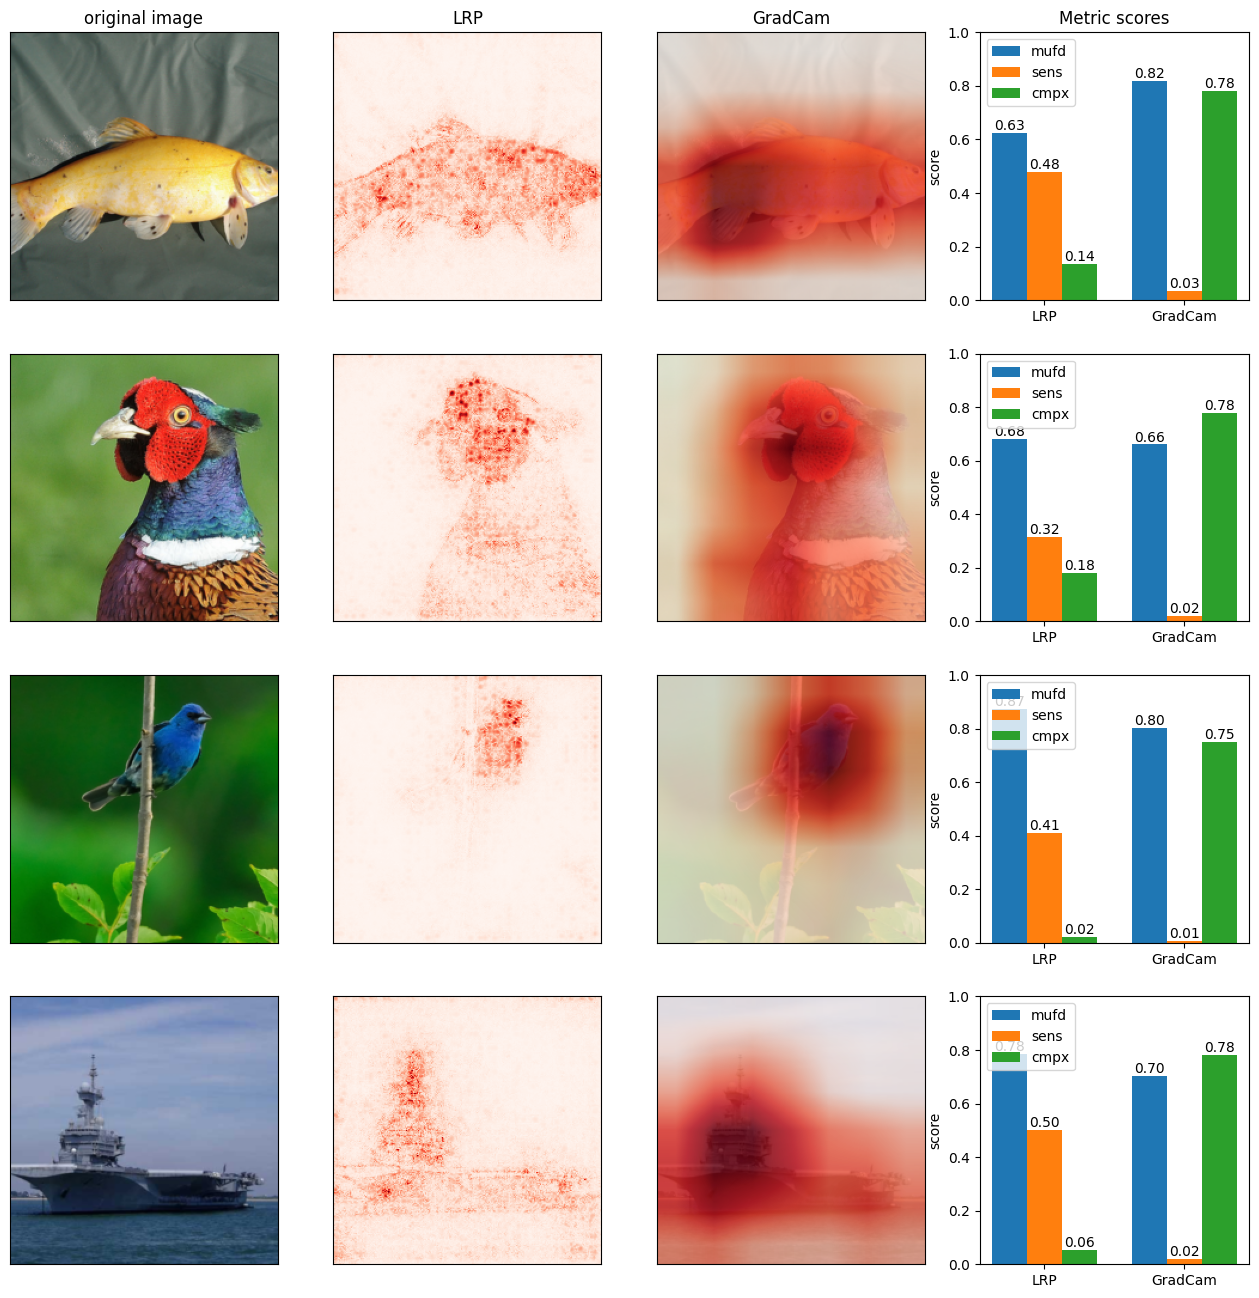

In [10]:
from scipy.stats import lognorm
import numpy as np

# define scoring function bounding metric values to [0, 1]
mufd_score = lambda m: (m+1)/2
sens_score = lambda m: lognorm.cdf(m, 1)
cmpx_score = lambda m: lognorm.cdf(m, 1)

# bound values and zip data
zipped_metrics_lrp = zip(
    mufd_score(mufd_lrp),
    sens_score(sens_lrp),
    cmpx_score(cmpx_lrp),
)
zipped_metrics_gcam = zip(
    mufd_score(mufd_gcam),
    sens_score(sens_gcam),
    cmpx_score(cmpx_gcam),
)
visdata_all = zip(
    inputs,
    attrs_lrp,
    attrs_gcam,
    zipped_metrics_lrp,
    zipped_metrics_gcam,
)

# postprocess for attributions
def postprocess_attr(attr, sign=None, scale=None):
    if sign == 'absolute':
        attr = torch.abs(attr)
    elif sign == 'positive':
        attr = torch.nn.functional.relu(attr)
    elif sign == 'negative':
        attr = -torch.nn.functional.relu(-attr)

    postprocessed = attr.permute((1, 2, 0)).sum(dim=-1)
    attr_max = torch.max(postprocessed)
    attr_min = torch.min(postprocessed)
    postprocessed = (postprocessed - attr_min) / (attr_max - attr_min)
    if scale == "sqrt":
        postprocessed = postprocessed.sqrt()
    return postprocessed.cpu().detach().numpy()

nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
for r, visdata in enumerate(visdata_all):
    axes[r, 0].imshow(denormalize_image(visdata[0], mean=transform.mean, std=transform.std))
    axes[r, 1].imshow(postprocess_attr(visdata[1], sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 2].imshow(denormalize_image(visdata[0], mean=transform.mean, std=transform.std))
    axes[r, 2].imshow(postprocess_attr(visdata[2]), cmap="Reds", alpha=.8)

    explainers = ("LRP", "GradCam")
    metric_data = dict(zip(("mufd", "sens", "cmpx"), zip(*visdata[3:])))
    x = np.arange(2)
    width = .25
    multiplier = 0
    for nm, values in metric_data.items():
        offset = width * multiplier
        rects = axes[r, 3].bar(x + offset, values, width, label=nm)
        axes[r, 3].bar_label(rects, padding=0, fmt="%.2f")
        multiplier += 1
    axes[r, 3].set_ylabel("score")
    axes[r, 3].set_xticks(x+width, explainers)
    axes[r, 3].set_ylim(0, 1)
    axes[r, 3].legend(loc="upper left", ncols=1)

    if r == 0:
        axes[r, 0].set_title("original image")
        axes[r, 1].set_title("LRP")
        axes[r, 2].set_title("GradCam")
        axes[r, 3].set_title("Metric scores")

for i, ax in enumerate(axes.flatten()):
    c = i % 4
    if c == 3:
        continue
    ax.set_xticks([])
    ax.set_yticks([])